### <center>Assignment</center>

In this assignment, you have to implement the input pipeline of the CNN model and try to write/read tfrecord with the **Oregon Wildlife** dataset.

We provide you with the complete code for the image classification task of the CNN model, but remove the part of the input pipeline. What you need to do is completing this part and training the model for at least 5 epochs.

**Description of Dataset:**

1. The raw data is from [kaggle](https://www.kaggle.com/virtualdvid/oregon-wildlife), which consists of 20 class image of wildlife.
2. We have filtered the raw data. You need to download the filtered image from [here](https://drive.google.com/file/d/1HncttRdMHeNjde8xQCjQQtTLG8dcaTJx/view?usp=sharing) and use them to complete the image classification task.
3. In the dataset we prepared for you, there are nearly 7,200 image, which contain **10 kinds** of wildlife.

The sample image is shown below:

![](https://nthu-datalab.github.io/ml/labs/11-1_CNN/imgsrc/red_fox.png)

#### Requirement:

- Try some the input transfromation mentioned above (e.g. shuffle, batch, repeat, map(random_crop, random_flip_left_right, ...)) but without optimization terms (e.g. prefetch, cache, num_parallel_calls)
    - Compare the performance and time consumption to the Naive one.
    - Note that it's important to take some examples and plot the image like block [84] to make sure theat the map function does as you desired
- Retrain your model with optimized terms, comparing the performance and time consumption.
- Training both models above for at least 3 epochs.
- Briefly summarize what you did and explain the performance results (accuracy and time consuming).
    - It's fine if you get worse performace after applying input transfromation, or get longer time consumption after applying data pipeline optimization. Just try to analyze the result and propose your assumption, e.g.
        - Is it possible that the more difficult training data after input transfromation may need more epochs to train to get better performance?
        - Which step is the bottleneck on your device? Why? Any other steps cost more time than your expect?


#### Note:

The `time.sleep(0.05)` in the example is to avoid concurrency issues that TAs are unable to solve at short notice. However, the duration **depends on devices** (the throughput between CPU and GPU maybe). For example, in our lab servers, 0.05 is enough for one newer computer while another computer still sometimes meet the error even we increase to 0.1. Therefore, if you meet strange errors like below and **not always meets the error when re-run the same code**, setting higher sleep time may help though it's slower. Errors that TA meets:

- `Expected size[1] in [0, 101], but got 224 [Op:Slice]` when `tf.image.random_crop(image, [tf.shape(image)[0],IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])`
- `ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [196,3] vs. shape[1] = [3,3] [Op:ConcatV2] name: concat` when `tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)`
- `Expected multiples argument to be a vector of length 1 but got length 3 [Op:Tile]` when `values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)`

#### Notification:

- Submit to **eeclass** with your ipynb (Lab11-1_{student_id}.ipynb)
- Deadline: 2023-11-9 (Thr) 23:59


In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             print(gpu)
#             tf.config.experimental.set_memory_growth(gpu, True)
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

In [3]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife\bald_eagle
oregon_wildlife\black_bear
oregon_wildlife\cougar
oregon_wildlife\deer
oregon_wildlife\nutria
oregon_wildlife\raccoon
oregon_wildlife\raven
oregon_wildlife\red_fox
oregon_wildlife\sea_lions
oregon_wildlife\virginia_opossum

total img num: 7168


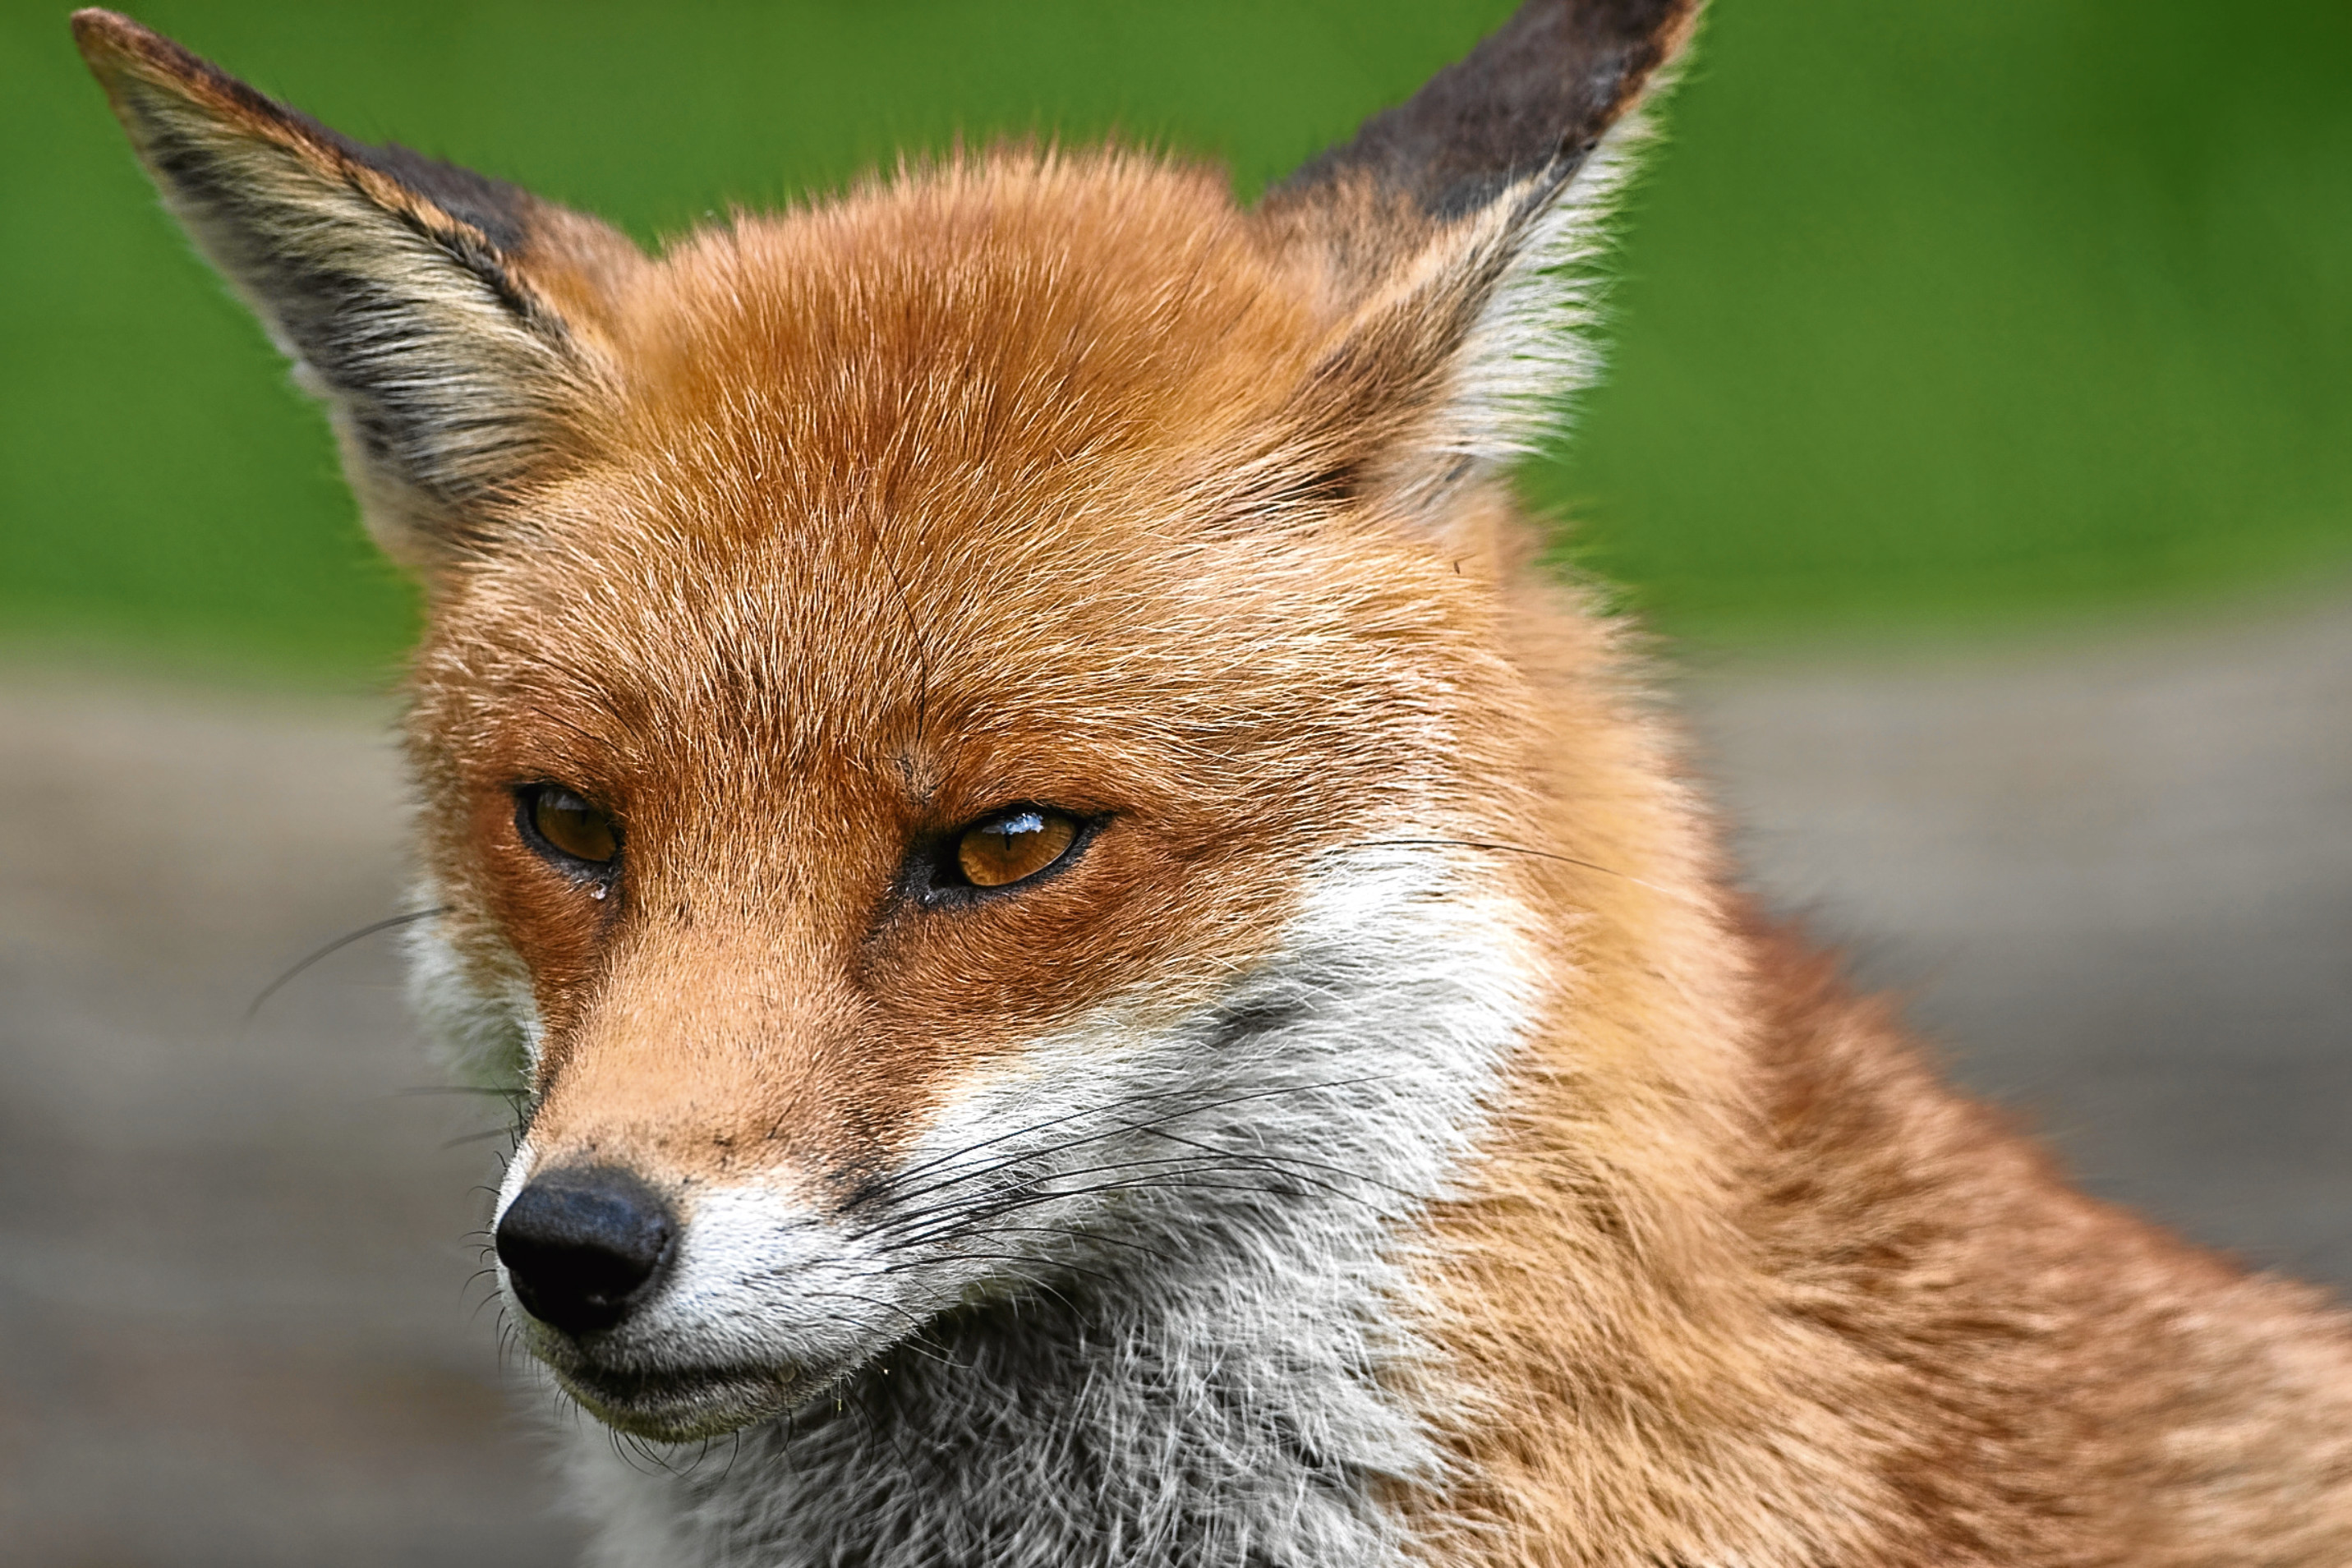

red_fox


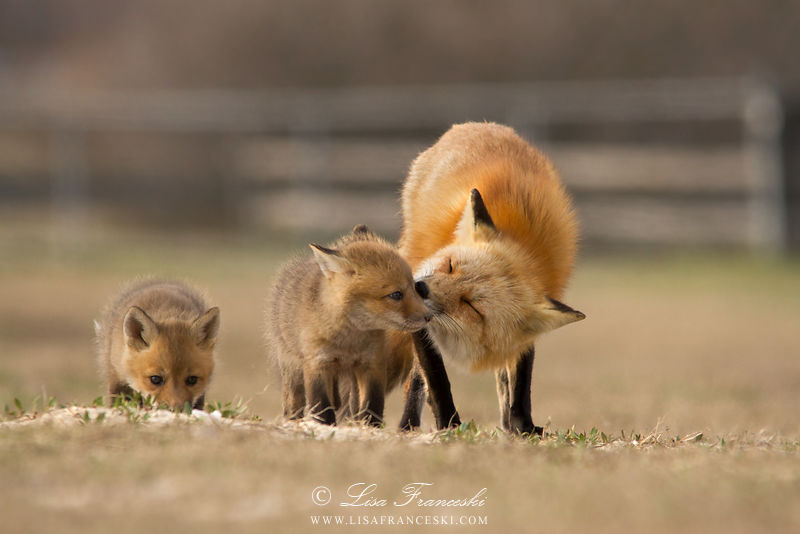

red_fox


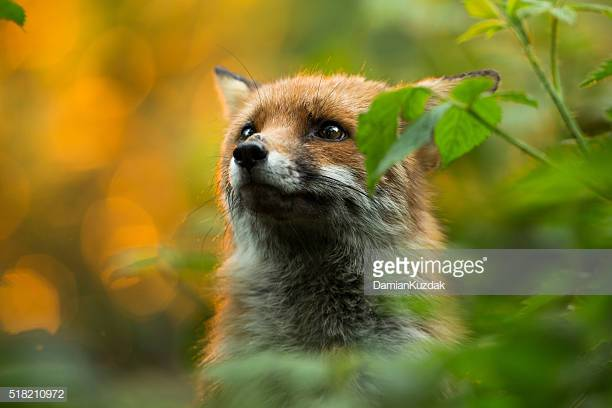

red_fox


In [4]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('\\')[-2])

In [5]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [6]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [7]:
# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [8]:
# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_label,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))

training data: 5734
testing data: 1434


In [9]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [10]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [11]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------
        
        # Reading the file        
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [12]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

In [13]:
# feel free to modify these two Settings.
BUFFER_SIZE = 1000
BATCH_SIZE = 64

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).batch(BATCH_SIZE, drop_remainder=True)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[7.9615946 0.012004 ]
 [7.9736004 0.2184165]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


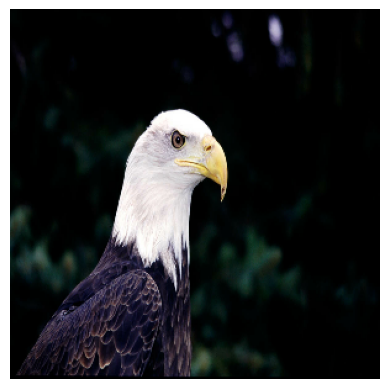

bald_eagle


In [14]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [15]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [16]:
wild_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [17]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [19]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [20]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            time.sleep(0.05)
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            time.sleep(0.05)
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [21]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)

start time:  10.6169308
training:


100%|██████████| 89/89 [02:13<00:00,  1.50s/it]

testing:



100%|██████████| 22/22 [00:30<00:00,  1.37s/it]

Epoch 1, Loss: 5.2796, Accuracy: 25.4213, test Loss: 1.2874, test Accuracy: 60.7955
training:



100%|██████████| 89/89 [01:54<00:00,  1.28s/it]

testing:



100%|██████████| 22/22 [00:29<00:00,  1.34s/it]

Epoch 2, Loss: 1.1650, Accuracy: 59.7086, test Loss: 0.7668, test Accuracy: 76.5625
training:



100%|██████████| 89/89 [01:57<00:00,  1.32s/it]

testing:



100%|██████████| 22/22 [00:28<00:00,  1.30s/it]

Epoch 3, Loss: 0.8338, Accuracy: 71.2079, test Loss: 0.5177, test Accuracy: 85.0852
Execution time: 453.46709930000003


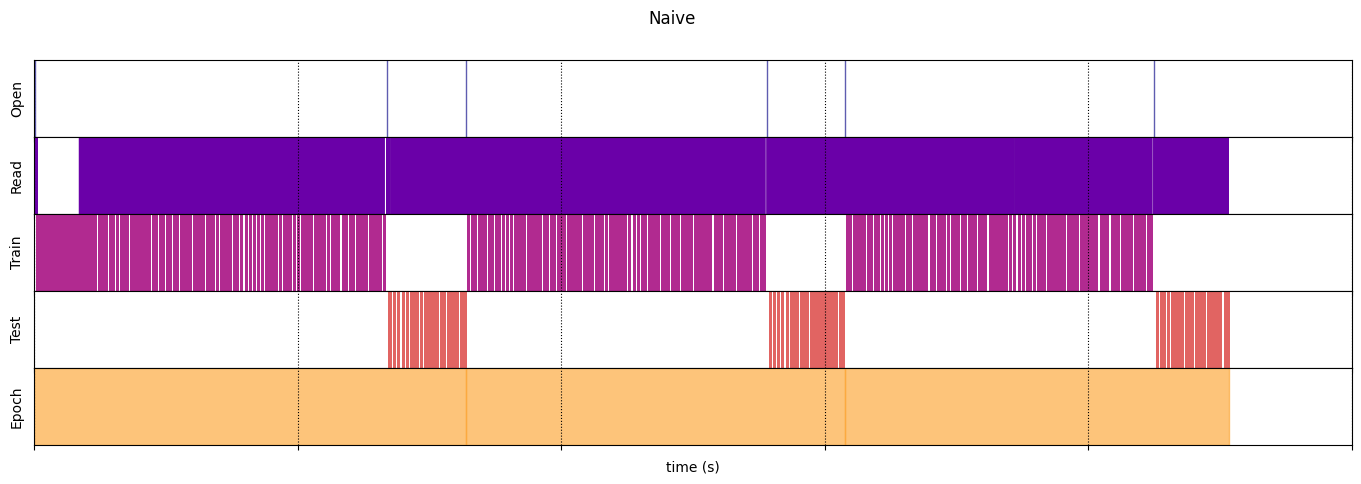

In [22]:
from lab11_1_lib import draw_timeline
import matplotlib.image as img

draw_timeline(timeline=timeline_Naive, title="Naive", min_width=500)

In [23]:
# def map_decorator(func):
#     def wrapper(steps, times, values, image, label):
#         # Use a tf.py_function to prevent auto-graph from compiling the method
#         return tf.py_function(
#             func,
#             inp=(steps, times, values, image, label),
#             Tout=(steps.dtype, times.dtype, values.dtype, image.dtype, label.dtype)
#         )
#     return wrapper

# @map_decorator
# def map_trian_with_transform(steps, times, values, image, label):
#     # sleep to avoid concurrency issue
#     time.sleep(0.05)
    
#     # record the enter time into map_fun()
#     map_enter = time.perf_counter()
    
#     # distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
#     # distorted_image = tf.image.resize(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED])
#     distorted_image = tf.image.random_flip_left_right(image)
#     distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
#     # distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
#     # distorted_image = tf.image.random_hue(distorted_image, max_delta=0.2)
#     distorted_image = tf.image.per_image_standardization(distorted_image)
    
#     map_elapsed = time.perf_counter() - map_enter
#     # ----------------
    
#     return tf.concat((steps, [["Map"]]), axis=0),\
#            tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
#            tf.concat((values, [values[-1]]), axis=0),\
#            distorted_image,\
#            label

# @map_decorator
# def map_test_with_transform(steps, times, values, image, label):
#     # sleep to avoid concurrency issue
#     time.sleep(0.01)
    
#     # record the enter time into map_fun_test()
#     map_enter = time.perf_counter()
    
#     # image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
#     # image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
#     # label = tf.one_hot(label,10)
#     # distorted_image = tf.image.resize(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED])
#     distorted_image = tf.image.per_image_standardization(image)
    
#     map_elapsed = time.perf_counter() - map_enter
#     # ----------------
    
#     return tf.concat((steps, [["Map"]]), axis=0),\
#            tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
#            tf.concat((values, [values[-1]]), axis=0),\
#            distorted_image,\
#            label

In [28]:
@tf.function
def map_trian_with_transform(steps, times, values, image, label):
    map_enter = time.perf_counter()

    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
        distorted_image,\
        label

# parse testing data
@tf.function
def map_test_with_transform(steps, times, values, image, label):
    map_enter = time.perf_counter()

    distorted_image = tf.image.per_image_standardization(image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
        distorted_image,\
        label

In [29]:
## TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
## Remember to define your own map functions with map_decorator before calling map

# Construct training Dataset with similar steps
dataset_train_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                            .shuffle(BUFFER_SIZE)\
                                            .batch(BATCH_SIZE, drop_remainder=True)\
                                            .map(map_trian_with_transform)
                                            
                                    
# Construct testing Dataset with similar steps
dataset_test_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .map(map_test_with_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


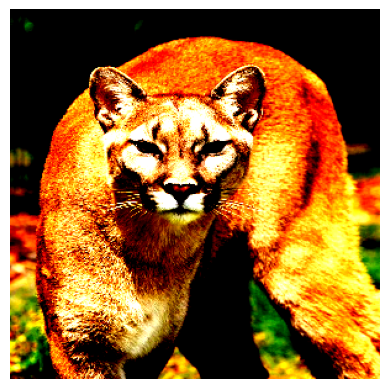

In [30]:
for steps, timings, counters, img, label in dataset_train_augmentation.take(1):
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()

In [31]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=3)

start time:  631.1029656
training:


100%|██████████| 89/89 [02:11<00:00,  1.48s/it]

testing:



100%|██████████| 22/22 [00:27<00:00,  1.26s/it]

Epoch 1, Loss: 6.6943, Accuracy: 51.9487, test Loss: 0.4077, test Accuracy: 88.3523
training:



100%|██████████| 89/89 [02:09<00:00,  1.45s/it]

testing:



100%|██████████| 22/22 [00:27<00:00,  1.26s/it]

Epoch 2, Loss: 0.5244, Accuracy: 83.2163, test Loss: 0.3118, test Accuracy: 90.6250
training:



100%|██████████| 89/89 [02:07<00:00,  1.43s/it]

testing:



100%|██████████| 22/22 [00:27<00:00,  1.25s/it]

Epoch 3, Loss: 0.3195, Accuracy: 89.8350, test Loss: 0.2040, test Accuracy: 93.1108
Execution time: 470.6231690000001


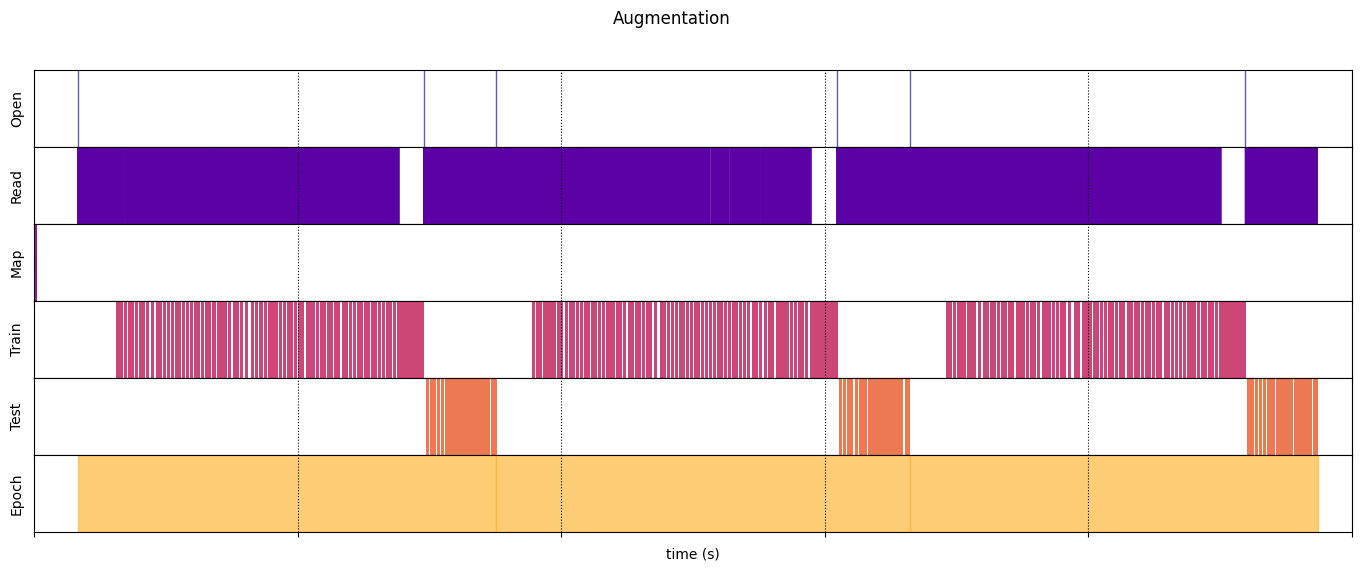

In [32]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=500)

In [39]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated

dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_trian_with_transform, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)
                                                
dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .batch(BATCH_SIZE, drop_remainder=True)\
                                                 .map(map_test_with_transform, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .cache()\
                                                 .prefetch(tf.data.AUTOTUNE)

In [40]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=3)

start time:  2756.3164365
training:


100%|██████████| 89/89 [01:57<00:00,  1.32s/it]

testing:



100%|██████████| 22/22 [00:29<00:00,  1.33s/it]

Epoch 1, Loss: 6.4813, Accuracy: 43.9256, test Loss: 0.5855, test Accuracy: 81.1080
training:



100%|██████████| 89/89 [00:39<00:00,  2.24it/s]

testing:



100%|██████████| 22/22 [00:09<00:00,  2.29it/s]

Epoch 2, Loss: 0.6030, Accuracy: 79.5997, test Loss: 0.2873, test Accuracy: 91.1932
training:



100%|██████████| 89/89 [00:41<00:00,  2.15it/s]

testing:



100%|██████████| 22/22 [00:09<00:00,  2.30it/s]

Epoch 3, Loss: 0.3440, Accuracy: 88.7289, test Loss: 0.2269, test Accuracy: 93.1818
Execution time: 246.75296170000001


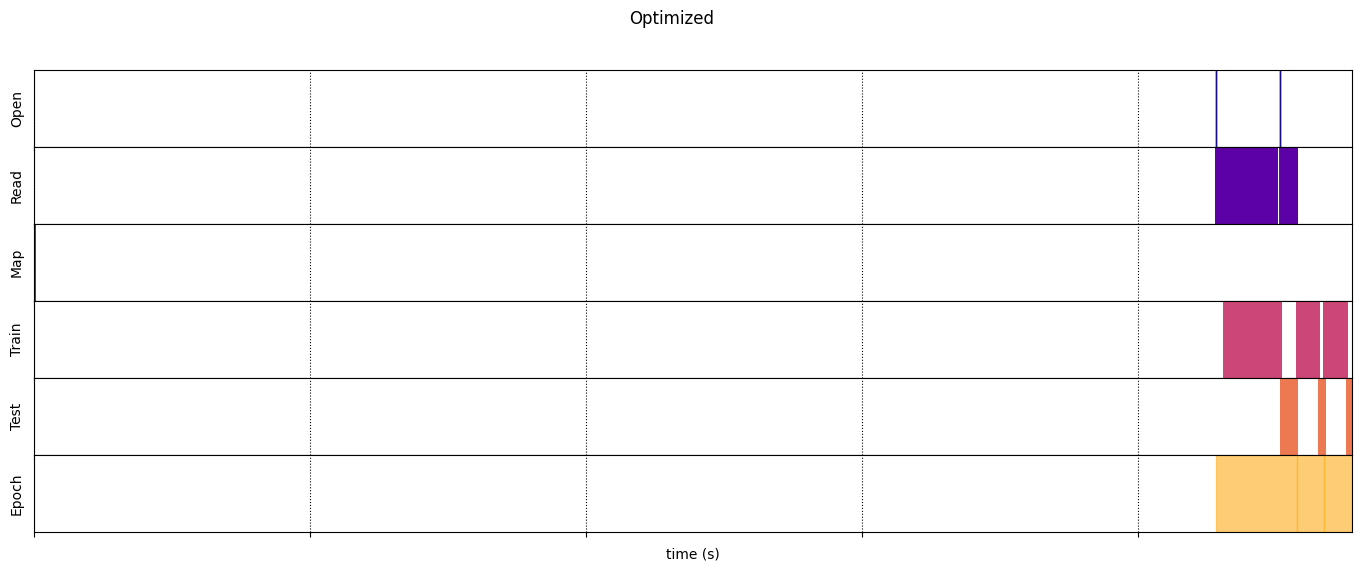

In [43]:
draw_timeline(timeline=timeline_Optimized, title="Optimized", min_width=100)

### Report

#### Naive version

- Execution time: 453 seconds
- Test accuracy: 85.08%

#### Transform version
- Execution time: 470 seconds
- Test accuracy: 93.11%
- Technique: shuffle, batch, map
- Transform: flip left right, brightness, standarization

#### Optimization version
- Execution time: 246 seconds
- Test accuracy: 93.18%
- Technique: num_parallel_calss, cache, prefetch

#### Summarize

在經過Transform對data進行augmentation後，模型的泛型會更好，所以在Test Accuracy上表現比naive的版本好，但是取而代之的是在執行效率上會比較不好一點，因為需要CPU去做預處理完才可以放進模型進行訓練。

而optimization的版本在可以維持幾乎相同表現的情況下，大幅提升了執行效率，幾乎將執行時間縮為一半，同時兼顧了模型泛化的表現能力以及訓練過程中的效率。

